In [11]:
import torch
from torchvision import datasets, transforms
from siren import Sine

In [3]:
batch_size = 1
transform=transforms.ToTensor()
dataset_train = datasets.MNIST('data', train=True, download=True,transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

In [8]:
im, label = next(iter(dataloader_train))
im = im - 0.5

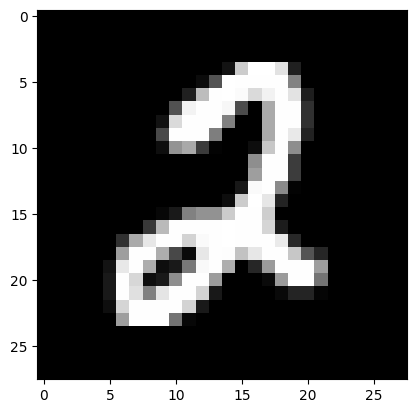

In [9]:
# plot image using maplotlib
import matplotlib.pyplot as plt
plt.imshow(im[0,0], cmap='gray')
plt.show()

In [58]:
class coordx_net(torch.nn.Module):
    def __init__(self, channels):
        super(coordx_net, self).__init__()
        self.channels=channels
        self.x_first = torch.nn.Linear(1,64)
        self.y_first = torch.nn.Linear(1,64)
        self.premerge_parallels = torch.nn.Sequential(
            Sine(),
            torch.nn.Linear(64,64),
            Sine(),
            torch.nn.Linear(64,64),
            Sine()
        )
        
        self.postmerge = torch.nn.Sequential(
            torch.nn.Linear(64,32),
            Sine(),
            torch.nn.Linear(32,self.channels),
            torch.nn.Sigmoid()
        )
    
    def merge(self,x,y):
        return torch.einsum("ik,jk->ijk",x,y)

    def forward(self, x, y):
        x1 = self.x_first(x)
        y1 = self.y_first(y)
        x2 = self.premerge_parallels(x1)
        y2 = self.premerge_parallels(y1)
        merged = self.merge(x2,y2)
        res = self.postmerge(merged)
        # reshape to (channels, x, y)
        res = res.permute(2,0,1)
        return res

In [59]:
x = torch.linspace(1, 28, 28).reshape(28,1)
y = torch.linspace(1, 28, 28).reshape(28,1)

In [60]:
net = coordx_net(channels=1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [73]:
for epoch in range(5000):
    optimizer.zero_grad()
    out = net(x,y)
    loss = loss_fn(out, im[0])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

Iteration: 0 | Loss: 0.19999174773693085
Iteration: 10 | Loss: 0.19997774064540863
Iteration: 20 | Loss: 0.19997020065784454
Iteration: 30 | Loss: 0.20007261633872986
Iteration: 40 | Loss: 0.19998981058597565
Iteration: 50 | Loss: 0.1999565064907074
Iteration: 60 | Loss: 0.19995634257793427
Iteration: 70 | Loss: 0.19994761049747467
Iteration: 80 | Loss: 0.1999436616897583
Iteration: 90 | Loss: 0.199940487742424
Iteration: 100 | Loss: 0.1999378204345703
Iteration: 110 | Loss: 0.19995523989200592
Iteration: 120 | Loss: 0.1999504119157791
Iteration: 130 | Loss: 0.19992989301681519
Iteration: 140 | Loss: 0.19992941617965698
Iteration: 150 | Loss: 0.1999262273311615
Iteration: 160 | Loss: 0.1999960094690323
Iteration: 170 | Loss: 0.1999478042125702
Iteration: 180 | Loss: 0.19992680847644806
Iteration: 190 | Loss: 0.19991758465766907
Iteration: 200 | Loss: 0.19991359114646912
Iteration: 210 | Loss: 0.19991059601306915
Iteration: 220 | Loss: 0.19990767538547516
Iteration: 230 | Loss: 0.199905

In [75]:
merged = net(x,y)
loss_fn(merged, im[0])

tensor(0.1997, grad_fn=<MseLossBackward0>)

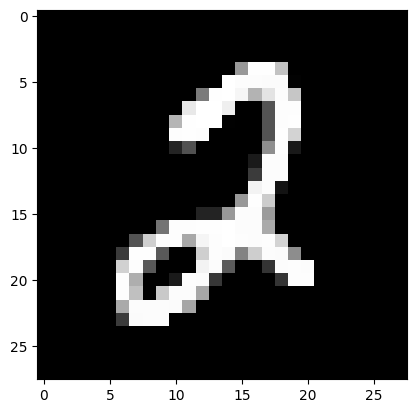

In [76]:
# plot the output of the network
plt.imshow(merged[0,:,:].detach().numpy(), cmap='gray')
plt.show()